# Unsupervised learning with a Graph-convolutional auto-encoder

## Imports and setup

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz

Using TensorFlow backend.


### Model drawing routines

In [2]:
def plot_ξ_distribution(glk, q_model, adj, gather, features):
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    q_pred = q_model.predict([adj, gather, features], batch_size=len(features))

    # KDE plots
    q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax1)
    ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ.T):
        ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Test graphs

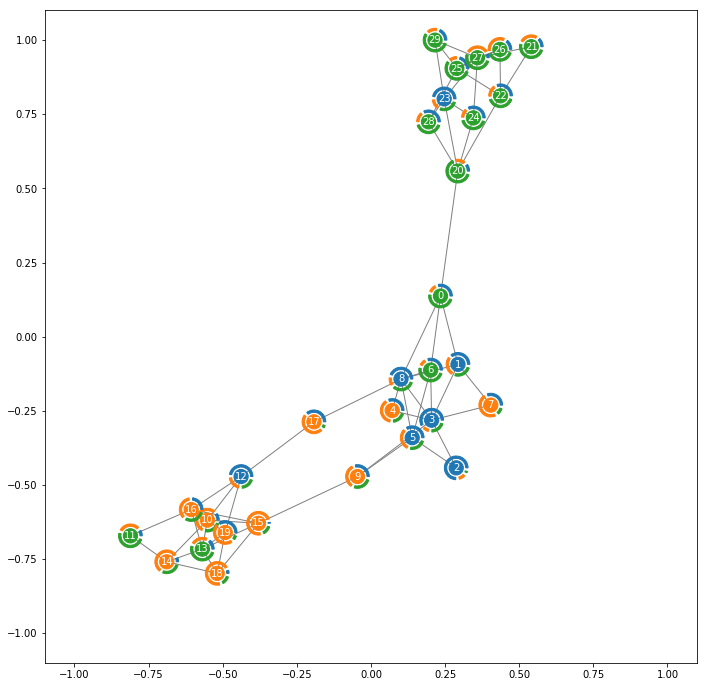

In [3]:
# Parameters
l = 3
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
#features = np.random.random((l * k, l)).astype(np.float32)
features = labels + np.abs(np.random.normal(loc=0.0, scale=1.5, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

In [5]:
# Build the VAE
n_nodes = l * k
adj = nx.adjacency_matrix(g).todense().astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

# Encoder
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)

# Decoder
p_input = keras.layers.Input(shape=(dim_ξ,), name='p_input')
p_layer1 = keras.layers.Dense(dim_l1,
                              use_bias=use_bias,
                              activation='relu',
                              kernel_regularizer='l2', bias_regularizer='l2',
                              name='p_layer1')(p_input)
p_adj = layers.Bilinear(0,
                        use_bias=use_bias,
                        #fixed_kernel=np.eye(dim_ξ),
                        kernel_regularizer='l2', bias_regularizer='l2',
                        name='p_adj')([p_layer1, p_layer1])
#p_v_μ_flat = keras.layers.Dense(dim_data,
#                                use_bias=use_bias,
#                                kernel_regularizer='l2', bias_regularizer='l2',
#                                name='p_v_mu_flat')(p_layer1)
#p_v_logD_flat = keras.layers.Dense(dim_data,
#                                   use_bias=use_bias,
#                                   kernel_regularizer='l2', bias_regularizer='l2',
#                                   name='p_v_logD_flat')(p_layer1)
#p_v_u_flat = keras.layers.Dense(dim_data,
#                                use_bias=use_bias,
#                                kernel_regularizer='l2', bias_regularizer='l2',
#                                name='p_v_u_flat')(p_layer1)
#p_v_μlogDu_flat = keras.layers.Concatenate(name='p_v_mulogDu_flat')(
#    [p_v_μ_flat, p_v_logD_flat, p_v_u_flat])
p_model = ae.Model(inputs=p_input,
                   outputs=[
                       p_adj,
                       #p_v_μlogDu_flat
                   ])

# Actual VAE
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    (p_model, (
        'SigmoidBernoulli',
        #codecs.Gaussian
    )),
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0, # p adj loss
        #1.0  # p v loss
    ],
)

Overall model


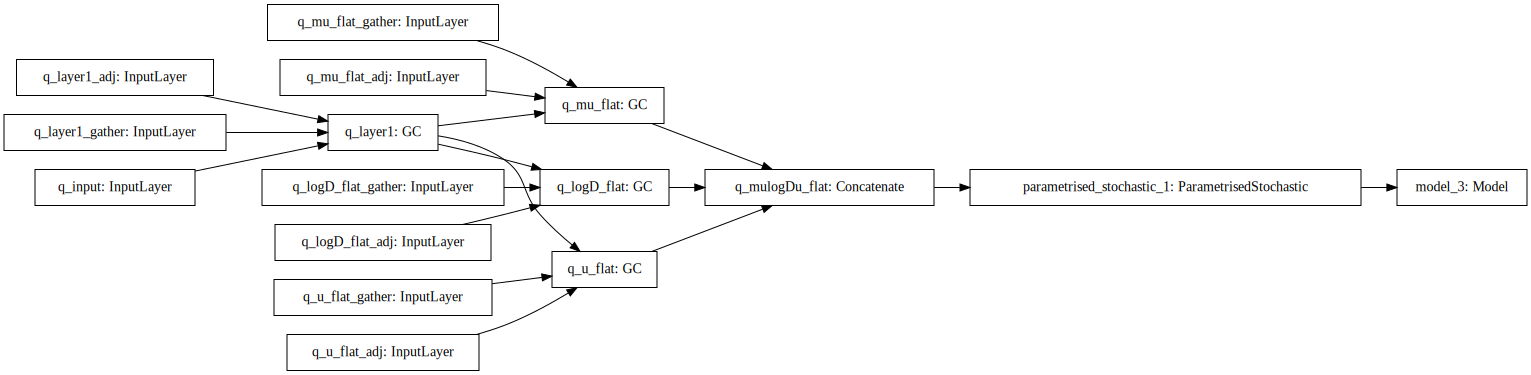

model_3


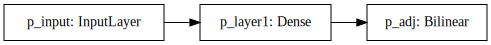

In [6]:
print('Overall model')
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

for layer in vae.layers:
    if not isinstance(layer, keras.Model):
        continue
    print(layer.name)
    display(SVG(model_to_dot(layer, rankdir='LR').create(prog='dot', format='svg')))

In [7]:
q_model.predict_on_fed_batch(utils.scale_center(features),
        feeds={'q_layer1_adj': adj,
               'q_layer1_gather': np.arange(n_nodes, dtype=np.int32),
               'q_mu_flat_adj': adj,
               'q_mu_flat_gather': np.arange(8, dtype=np.int32),
               'q_logD_flat_adj': adj,
               'q_logD_flat_gather': np.arange(8, dtype=np.int32),
               'q_u_flat_adj': adj,
               'q_u_flat_gather': np.arange(8, dtype=np.int32)}).shape

(8, 6)

In [9]:
vae.predict_on_fed_batch(utils.scale_center(features),
        feeds={'q_layer1_adj': adj,
               'q_layer1_gather': np.arange(n_nodes, dtype=np.int32),
               'q_mu_flat_adj': adj,
               'q_mu_flat_gather': np.arange(9, dtype=np.int32),
               'q_logD_flat_adj': adj,
               'q_logD_flat_gather': np.arange(9, dtype=np.int32),
               'q_u_flat_adj': adj,
               'q_u_flat_gather': np.arange(9, dtype=np.int32)})[1].shape

(5, 9, 9)

**Before training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

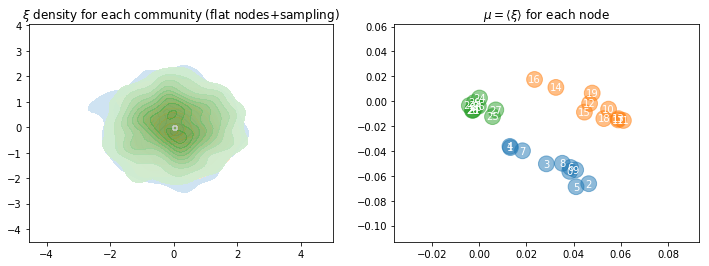

In [8]:
plot_ξ_distribution((g, l, k), q_model, adj, np.arange(n_nodes), utils.scale_center(features))

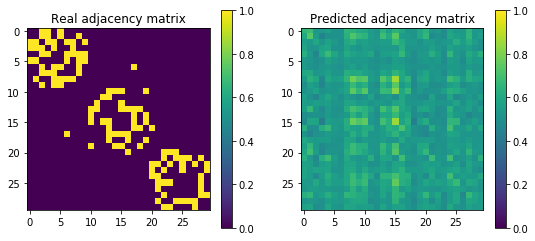

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(scipy.special.expit(vae.predict_on_batch([adj, np.arange(n_nodes), utils.scale_center(features)])[1].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

**Train**

In [9]:
rm -r ./logs

In [10]:
n_epochs = 5000

def batches():
    x = [
        adj,
        np.arange(n_nodes),
        utils.scale_center(features),
    ]
    y = [
        np.zeros(n_nodes),
        utils.expand_dims_tile(adj + np.eye(adj.shape[0]), 0, n_ξ_samples),
        #utils.scale_center(features),
    ]
    while True:
        yield (x, y)

vae.fit_generator(batches(),
                  steps_per_epoch=1,
                  epochs=n_epochs,
                  check_array_lengths=False,
                  shuffle=False,
                  verbose=0,
                  callbacks=[
                      keras.callbacks.TensorBoard()
                  ])

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

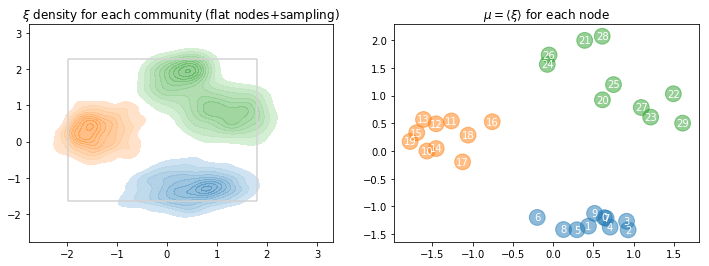

In [11]:
plot_ξ_distribution((g, l, k), q_model, adj, np.arange(n_nodes), utils.scale_center(features))

Predicted adjacency matrix:

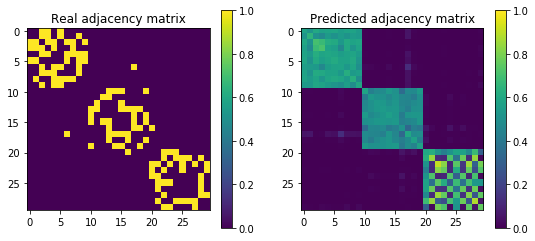

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(scipy.special.expit(vae.predict_on_batch([adj, np.arange(n_nodes), utils.scale_center(features)])[1].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

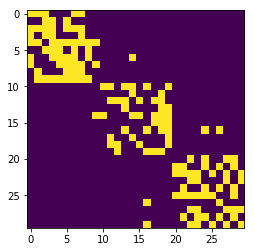

In [13]:
plt.imshow(np.random.binomial(1, scipy.special.expit(vae.predict_on_batch([adj, np.arange(n_nodes), utils.scale_center(features)])[1].mean(axis=0))))

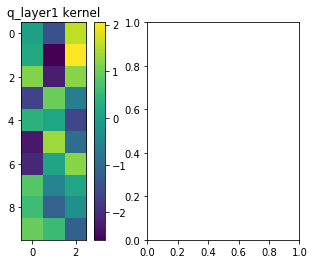

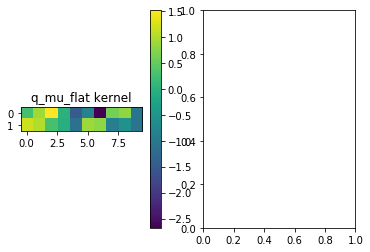

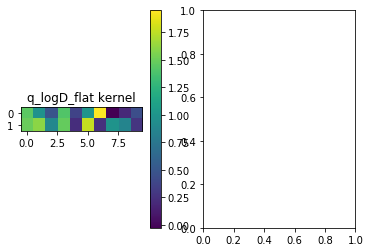

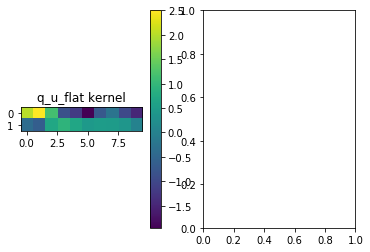

In [14]:
for layer in q_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)

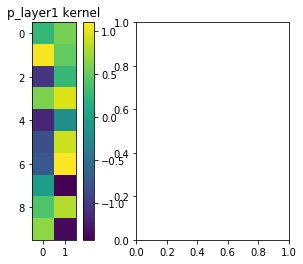

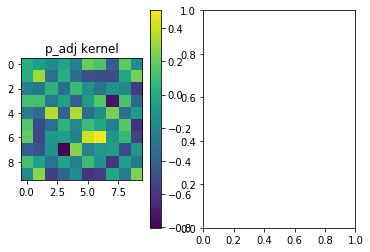

In [15]:
for layer in p_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)